In [165]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hypertools as hyp
import time, glob, itertools
import geoplot as gplt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib inline

In [2]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)

In [3]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})


In [4]:
frame['HUC_12']=frame.HUC_12.astype(str)

In [5]:
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [6]:
inHouse=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\inhouse_elemental.csv')

In [7]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(inHouse.longitude, inHouse.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(inHouse, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

<IPython.core.display.Javascript object>


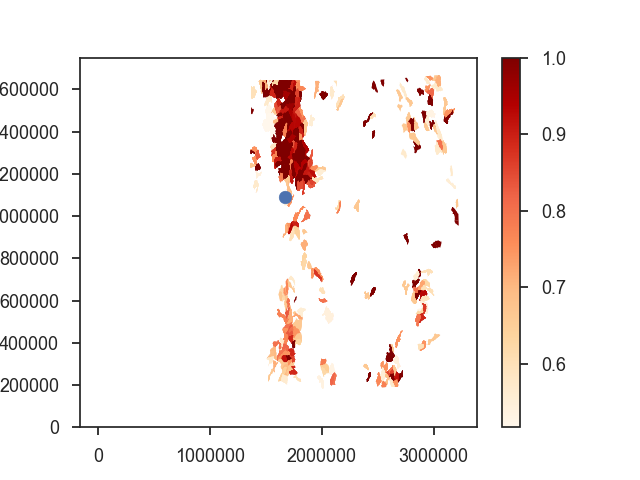

In [8]:
fig, ax = plt.subplots()
CaptainHucstable[(CaptainHucstable['element']=='co_ppm') &
                 (CaptainHucstable['bins_ppm']>10) & (CaptainHucstable['prob']>0.5)].plot(ax=ax, column='prob', cmap='OrRd', legend=True)
projGeoDF.iloc[0:1].plot(ax=ax)


In [10]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [337]:
validations=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\validationmap.csv')

In [345]:
val_huc[val_huc['Sample_ID']==validations.loc[0].Sample_ID].HUC_12.values[0]

'101800061003'

In [464]:
from scipy.stats import mode as spmode
actual =[]
predicted_values = []
for i in tqdm(range(len(validations.Sample_ID))):
    basin = val_huc[val_huc['Sample_ID']==validations.loc[0].Sample_ID].HUC_12.unique()[0]
    predicted = CaptainHucstable[(CaptainHucstable['element']=='co_ppm')& (CaptainHucstable['HUC_12']==str(basin)) 
                        &(CaptainHucstable['formation'].str.contains(validations.loc[i].formation[0:10]))
                           ][['bins_ppm', 'prob', 'formation']].sort_values(by=['bins_ppm'], ascending=True).iloc[0:] 
    inhouse_samples = sorted(val_huc[val_huc['HUC_12']== str(basin)]['co_ppm'].dropna().values)
    actual.append(inhouse_samples)
    predicted_rolling = sorted(np.random.choice(trying.bins_ppm.values, len(inhouse_samples), p=trying.prob.values)
                              )+np.random.randint(-2,2,len(inhouse_samples))
    predicted_values.append(predicted_rolling)



100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [03:27<00:00,  2.04s/it]


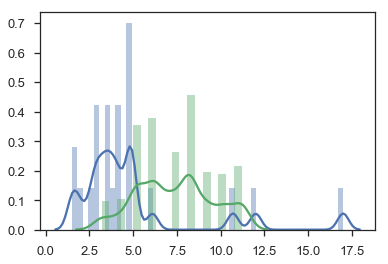

In [465]:
sns.distplot(np.asarray(actual).flatten())
sns.distplot(np.asarray(predicted_values).flatten())